# Shot noise sim from HIPASS HIMF

This is an attempt to make some sort of simulation of HI galaxies from the HIPASS HI mass function. See Zwaan, at al. 2013 for reference. 

In [190]:
%matplotlib inline

import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats

Take a bunch of useful parameters. Explore HI mass range from 6 to 11 solar masses.

In [372]:
# bunch of constants/parameters
h = 6.62607e-34
omeg_m = 0.3139
omeg_l = 0.6861
c = 2.99792e8
A = 2.869e-15
m = 1.67372e-27
k = 1.38064e-23
v = 1.42041e9
z = 0.08
H = 2.26719e-18
# solar mass in kg
Ms = 1.989e30
#rhoc = 2.49732453e41 # in kg/Mpc^3
rhoc = 6.1e7*Ms / 3.8e-4

# conversion from M_HI to T_b
C = 3 * h * c**3 * A * (1+z)**2 / (31*np.pi * m * k * v**2 * H)
# volume of box in metres (convert from Mpc)
V = (139 * 1.e6 * 3.08568025e16)**3
Nv = 139

# Coeff between T_b and Omega_HI (ie T*Omega_HI = T_b)
T = 0.39 * ((omeg_m + omeg_l * (1+z)**-3) / 0.29)**-0.5 *\
    ((1.0 + z) / 2.5)**0.5

In [380]:
phi, mstar, alpha = 8.6e-3, 10.**9.79, -1.30
#alpha += 0.02
#mstar = 10.**(9.79*0.85)
#mstar *= 0.85
#phi *= 1.15
#mlow = 10.**7.

x = np.logspace(np.log10(6.), np.log10(11.), 240000)

x[:10]

array([ 6.        ,  6.00001515,  6.00003031,  6.00004546,  6.00006061,
        6.00007577,  6.00009092,  6.00010608,  6.00012123,  6.00013638])

We take a conventional definition of the Schechter function. Note that it's often given as a differential, so integration is required to return the proper form.

Zwaan uses $h_{75}$, so we convert to $h_{100}$ for comparison with Parkes. Zwaan also outlines some biases on the Schechter parameters and the function overall, which I'll include here.

In [381]:
#mf = phi * (x / mstar)**(1 + alpha) * np.exp(-x / mstar) / (-1 - alpha)
mf =  phi * (10**x / mstar)**(alpha + 1) *\
         np.exp(-10**x / mstar) * (100. / 100.)**3
    
# attempting some low-mass cutoff
#mf *= np.exp(-(mlow / 10**x)**(3.))

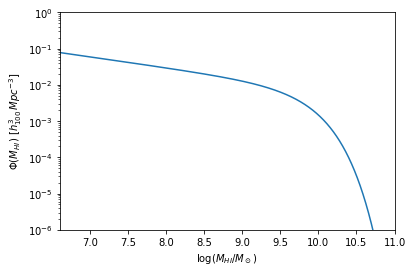

In [382]:
# PLOT the HIMF

plt.plot(x, mf)
plt.xlim([6.6, 11.])
plt.ylim([1e-6, 1.e0])
plt.xlabel('log$(M_{{HI}}/M_\odot)$')
plt.ylabel('$\Phi(M_{{HI}})$ [$h_{100}^3\, {Mpc}^{-3}$]')
plt.yscale('log')
plt.show()

Now we choose mass bins over which we'll integrate the function to return the mass density of galaxies for each bin. The function integrated over the entire domain is the HI mass density; divided by the critical density, this is $\Omega_\text{HI}$.

In [385]:
bins = np.logspace((6.8), (10.6), 50)
nbin = np.ones_like(bins[:-1])
cent = np.ones_like(bins[:-1])
var = 10**np.logspace(np.log10(6.8), np.log10(10.6), len(mf))

for bb in range(len(bins)-1):
    cent[bb] *= (bins[bb] + bins[bb+1]) / 2   
    mask = (var>=bins[bb]) & (var<bins[bb+1])
    nbin[bb] *= (integrate.simps(mf[mask], var[mask])) / cent[bb]

rho = integrate.simps(mf, var)
print rho
# brightness temp from integrating
rho * Ms / rhoc 

67243885.9949


0.00041889633898490344

In [377]:
probs = np.append(nbin, 1-np.sum(nbin))
masses = np.append(cent, 0)

In [345]:
lbox = 139
np.random.seed(seed=1)
box = np.random.choice(masses, size=(lbox,lbox,lbox), p=probs)

#plt.hist(box.flatten(), bins=bins)
#plt.xlabel('log$(M_{{HI}}/M_\odot)$')
#plt.ylabel('N')
#plt.show()

This box is a box of HI masses. However, because each voxel is $1 \text{Mpc}^3$, these masses are also HI density estimates, in solar masses. Multiplying by $M_\odot$ and dividing by $\rho_\text{crit}$, these return estimates for $\Omega_\text{HI}$.

In [346]:
massbox = (box)

# brightness temp from simulated box
np.mean(massbox) * Ms / rhoc * T 

test = box * Ms / rhoc * T
print np.var(test) 
np.mean(test)

3.35381556445e-10


2.2263725719179865e-06